# First Multispectral Win: Loading and Visualizing Satellite Data

This notebook walks through the complete process of:
1. Searching for satellite imagery using a STAC API
2. Loading specific spectral bands into Python
3. Creating a "true color" image (what humans would see)
4. Computing NDVI to reveal vegetation patterns invisible to the human eye

**Data source:** Sentinel-2 Level-2A (surface reflectance) via Microsoft Planetary Computer

---
## 1. Setup and Imports

We need several libraries:
- `pystac_client` — Search satellite data catalogs using the STAC standard
- `planetary_computer` — Sign URLs to access Microsoft's free satellite data
- `odc.stac` — Load STAC items directly into xarray datasets
- `numpy` / `matplotlib` — Standard data manipulation and plotting

In [3]:
from pystac_client import Client
import planetary_computer as pc
from odc.stac import stac_load

import numpy as np
import matplotlib.pyplot as plt

---
## 2. Connect to the STAC Catalog

**What is STAC?**  
STAC (SpatioTemporal Asset Catalog) is a standard way to describe and search geospatial data. Think of it like a search engine for satellite imagery.

Microsoft Planetary Computer hosts petabytes of free Earth observation data and provides a STAC API to search it.

In [4]:
catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")
print("Connected to Planetary Computer STAC API")

Connected to Planetary Computer STAC API


---
## 3. Define Our Area of Interest

We specify a **bounding box** (bbox) using coordinates:  
`[min_longitude, min_latitude, max_longitude, max_latitude]`

This area is near Fort Collins, Colorado — a mix of irrigated farmland and urban development that makes for interesting satellite imagery.

In [41]:
# Bounding box: [min_lon, min_lat, max_lon, max_lat]
# Note: Google Maps gives lat,lon — but bbox needs lon,lat order!
bbox = [-105.00046265789766, 40.61040537905372, -104.97822774714184, 40.62419090978705]

print(f"Area of interest:")
print(f"  Longitude: {bbox[0]} to {bbox[2]}")
print(f"  Latitude:  {bbox[1]} to {bbox[3]}")

Area of interest:
  Longitude: -105.00046265789766 to -104.97822774714184
  Latitude:  40.61040537905372 to 40.62419090978705


---
## 4. Search for Satellite Imagery

We search for **Sentinel-2 Level-2A** data, which provides surface reflectance (already corrected for atmospheric effects).

**Search parameters:**
- `collections` — Which satellite/product to search
- `bbox` — Our area of interest
- `datetime` — Date range to search
- `query` — Additional filters (here: cloud cover < 20%)

In [42]:
search = catalog.search(
    collections=["sentinel-2-l2a"],
    bbox=bbox,
    datetime="2024-07-01/2024-08-31",  # Summer 2024
    query={"eo:cloud_cover": {"lt": 20}},  # Less than 20% clouds
)

items = list(search.get_items())
print(f"Found {len(items)} images matching our criteria")

Found 63 images matching our criteria


---
## 5. Select and Sign an Image

We'll use the first (most recent) result. 

**Why "sign" the item?**  
Planetary Computer data is stored in Azure cloud storage. The `pc.sign()` function adds temporary authentication tokens to the URLs so we can download the actual pixel data.

In [43]:
if len(items) == 0:
    raise ValueError("No satellite images found! Try a different date range or location.")

item = items[0]
print(f"Selected image:")
print(f"  Date: {item.datetime}")
print(f"  Cloud cover: {item.properties.get('eo:cloud_cover', 'N/A'):.2f}%")
print(f"  ID: {item.id}")

# Sign the item to get accessible URLs
signed_item = pc.sign(item)

Selected image:
  Date: 2024-08-30 17:39:01.024000+00:00
  Cloud cover: 0.00%
  ID: S2A_MSIL2A_20240830T173901_R098_T13TEF_20240831T004052


---
## 6. Load Spectral Bands

**What are spectral bands?**  
Unlike a regular camera that captures RGB, satellites measure light in many specific wavelength ranges (bands). Each band reveals different information about the surface.

**Sentinel-2 bands we're loading:**
| Band | Name | Wavelength | What it shows |
|------|------|------------|---------------|
| B02 | Blue | 490 nm | Water, atmosphere |
| B03 | Green | 560 nm | Vegetation vigor |
| B04 | Red | 665 nm | Chlorophyll absorption |
| B08 | NIR | 842 nm | Vegetation structure (invisible to humans!) |

The data is loaded into an **xarray Dataset** — a labeled, multi-dimensional array that keeps track of coordinates and metadata.

In [44]:
data = stac_load(
    [signed_item],
    bands=["B02", "B03", "B04", "B08"],
    bbox=bbox,
    crs="EPSG:4326",        # Coordinate system (lat/lon)
    resolution=0.0001,      # ~10 meters per pixel at this latitude
    groupby="solar_day",
)

print("Loaded data:")
print(f"  Dimensions: {dict(data.dims)}")
print(f"  Bands: {list(data.data_vars)}")
print(f"\nB04 (Red) value range: {float(data['B04'].min()):.0f} to {float(data['B04'].max()):.0f}")

Loaded data:
  Dimensions: {'latitude': 138, 'longitude': 223, 'time': 1}
  Bands: ['B02', 'B03', 'B04', 'B08']

B04 (Red) value range: 1167 to 6400


/var/folders/fw/7z91hnr90wg20_4t4wd6h2280000gn/T/ipykernel_54842/598562469.py:11: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print(f"  Dimensions: {dict(data.dims)}")


---
## 7. Create a True Color (RGB) Image

**What is "true color"?**  
A true color image uses Red, Green, and Blue bands to approximate what the human eye would see.

**Why normalize?**  
Raw satellite values are reflectance measurements (typically 0-10000). We need to scale them to 0-1 for display. We use percentile-based normalization to handle outliers and get good contrast.

In [45]:
def normalize(img, pmin=2, pmax=98):
    """
    Normalize image values to 0-1 range using percentiles.
    This handles outliers better than simple min/max scaling.
    """
    lo, hi = np.nanpercentile(img, [pmin, pmax])
    return np.clip((img - lo) / (hi - lo + 1e-6), 0, 1)

# Stack bands into an RGB image
# Note: Sentinel-2 bands are B04=Red, B03=Green, B02=Blue
rgb = np.stack([
    data["B04"].isel(time=0).values,  # Red
    data["B03"].isel(time=0).values,  # Green
    data["B02"].isel(time=0).values,  # Blue
], axis=-1)

rgb_normalized = normalize(rgb)
print(f"RGB image shape: {rgb_normalized.shape} (height, width, channels)")

RGB image shape: (138, 223, 3) (height, width, channels)


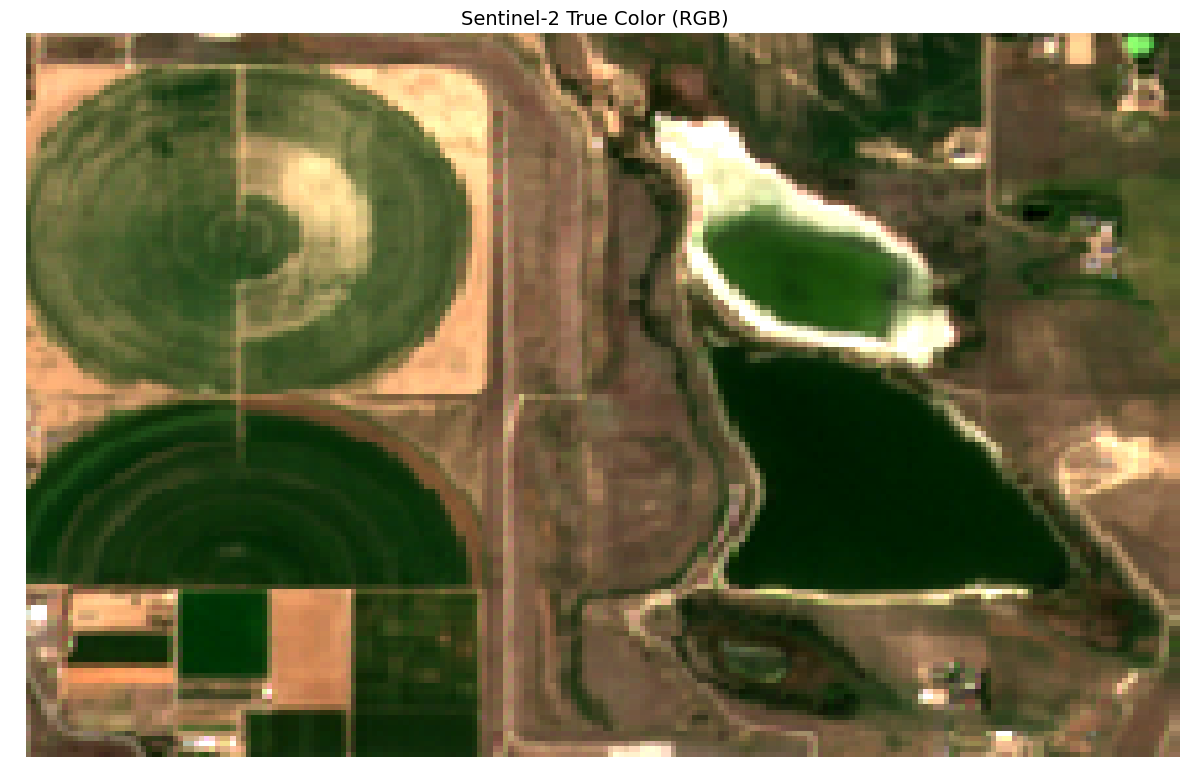

In [46]:
fig, ax = plt.subplots(figsize=(12, 10))
ax.imshow(rgb_normalized)
ax.set_title("Sentinel-2 True Color (RGB)", fontsize=14)
ax.axis("off")
plt.tight_layout()
plt.show()

### Interpreting the True Color Image

What you're seeing:
- **Circular green shapes** — Center-pivot irrigation farms (the circular pattern comes from rotating sprinkler systems)
- **Brown/tan areas** — Dry land, bare soil, or harvested fields
- **Gray grid patterns** — Urban/suburban development
- **Dark green patches** — Trees or dense vegetation

---
## 8. Compute NDVI (Normalized Difference Vegetation Index)

**The key insight:** Healthy vegetation has a unique spectral signature:
- **Absorbs** red light (for photosynthesis)
- **Strongly reflects** near-infrared (NIR) light

NDVI exploits this by computing the ratio:

$$NDVI = \frac{NIR - Red}{NIR + Red}$$

**NDVI values:**
- **0.6 to 1.0** — Dense, healthy vegetation
- **0.2 to 0.6** — Sparse or stressed vegetation
- **0.0 to 0.2** — Bare soil, rocks, dead plants
- **-1.0 to 0.0** — Water, snow, clouds

**Why this matters:** NDVI reveals vegetation health that's invisible to the human eye. Two fields might look similarly green, but NDVI shows which one is actually thriving.

In [48]:
# Extract NIR and Red bands as float arrays
nir = data["B08"].isel(time=0).values.astype("float32")
red = data["B04"].isel(time=0).values.astype("float32")

# Compute NDVI
# The small epsilon (1e-6) prevents division by zero
ndvi = (nir - red) / (nir + red + 1e-6)

print(f"NDVI statistics:")
print(f"  Min: {np.nanmin(ndvi):.2f}")
print(f"  Max: {np.nanmax(ndvi):.2f}")
print(f"  Mean: {np.nanmean(ndvi):.2f}")

NDVI statistics:
  Min: -0.08
  Max: 0.71
  Mean: 0.28


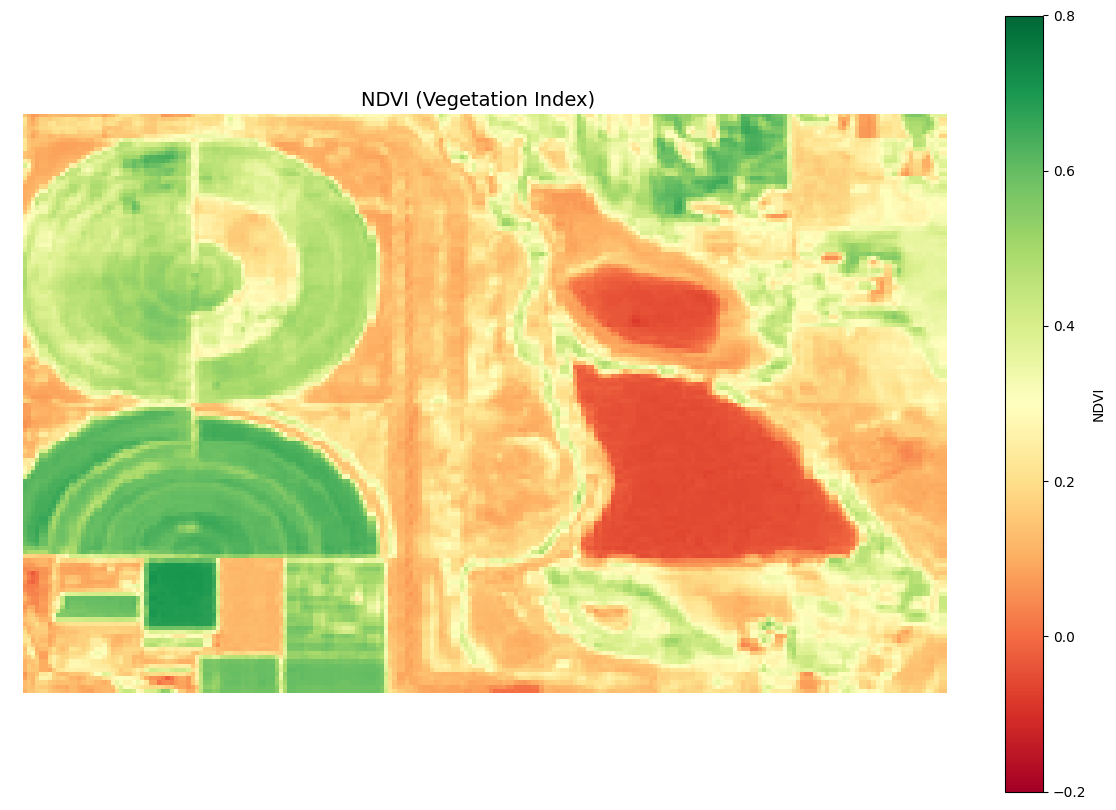

In [49]:
fig, ax = plt.subplots(figsize=(12, 10))
im = ax.imshow(ndvi, cmap='RdYlGn', vmin=-0.2, vmax=0.8)
ax.set_title("NDVI (Vegetation Index)", fontsize=14)
ax.axis("off")
plt.colorbar(im, ax=ax, label="NDVI", shrink=0.8)
plt.tight_layout()
plt.show()

### Interpreting the NDVI Image

Compare this to the true color image above:

- **Dark green (NDVI 0.6-0.8)** — Healthy, actively growing crops in the irrigated circular fields
- **Yellow/orange (NDVI 0.2-0.4)** — Sparse vegetation, dry grass, or stressed plants
- **Red (NDVI < 0.2)** — Bare soil, roads, buildings, parking lots

Notice how NDVI makes the difference between healthy and stressed vegetation much more obvious than the true color image!

---
## 9. Side-by-Side Comparison

Let's put both images next to each other to see how NDVI reveals information beyond what's visible in true color.

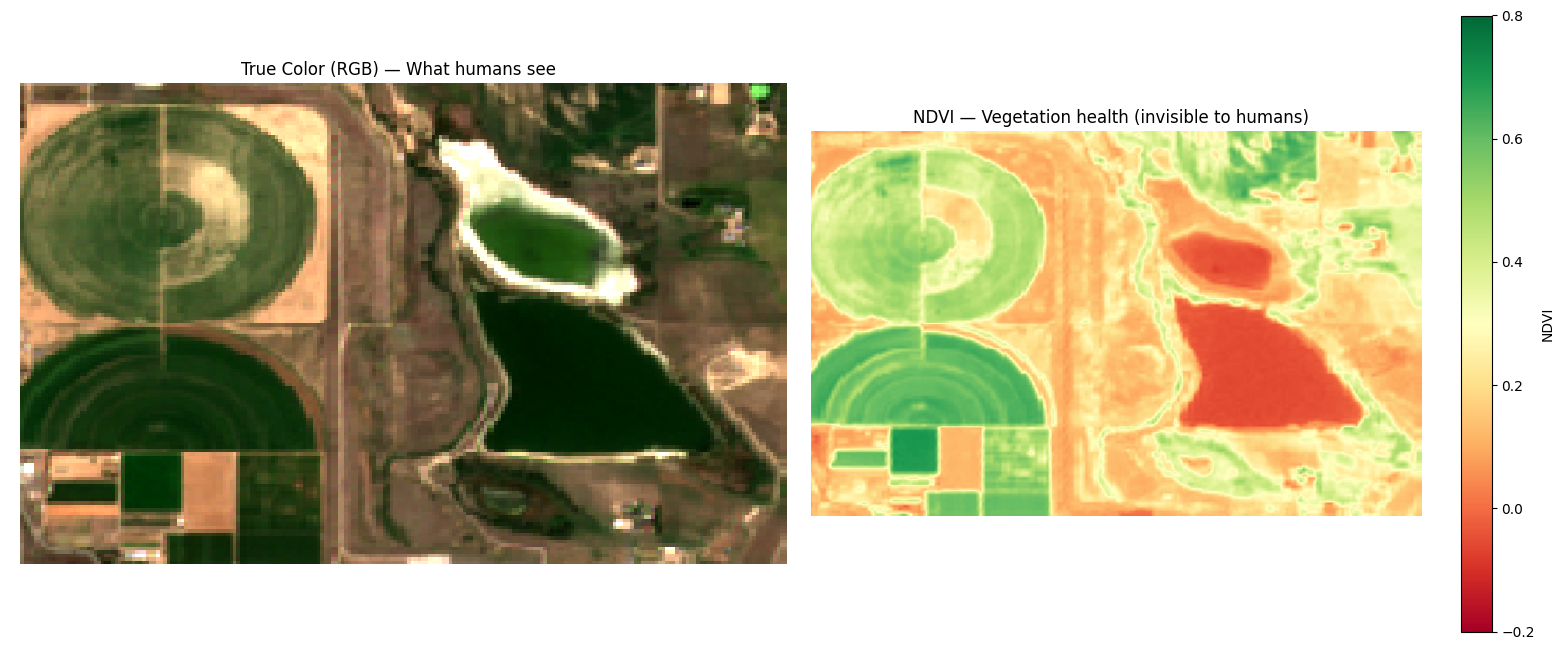

In [50]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# True color
axes[0].imshow(rgb_normalized)
axes[0].set_title("True Color (RGB) — What humans see", fontsize=12)
axes[0].axis("off")

# NDVI
im = axes[1].imshow(ndvi, cmap='RdYlGn', vmin=-0.2, vmax=0.8)
axes[1].set_title("NDVI — Vegetation health (invisible to humans)", fontsize=12)
axes[1].axis("off")
plt.colorbar(im, ax=axes[1], label="NDVI", shrink=0.8)

plt.tight_layout()
plt.show()

---
## Summary

**What we accomplished:**
1. Connected to a satellite data catalog (STAC API)
2. Searched for cloud-free imagery over a specific location and time
3. Loaded multiple spectral bands into Python
4. Created a true color visualization
5. Computed NDVI to reveal vegetation patterns

**Key concepts:**
- Satellite images are **measurements**, not photographs
- Different **spectral bands** reveal different surface properties
- **NDVI** uses the ratio of NIR to Red to quantify vegetation health
- The same workflow applies to any location on Earth — just change the `bbox`!

**Next steps to explore:**
- Try a different location (your hometown?)
- Compare the same area across different seasons
- Explore other spectral indices (water, built-up areas, etc.)